# Script to identify which MERRA-2 grid cells are within the Alpine-3D bounding box. The output of the script should look like this.
```
[INPUT]
VSTATION1 = latlon -65.5 -60.625 0
VSTATION2 = latlon -71 70 0
```

## Import python packages

In [1]:
import xarray as xr
import numpy as np
from osgeo import osr
from pyproj import Geod
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## Define Alpine-3D coordinate corners (see SNOWPACK_WAIS/setup/input_surface_grids/create_input_surface_grids.sh)

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


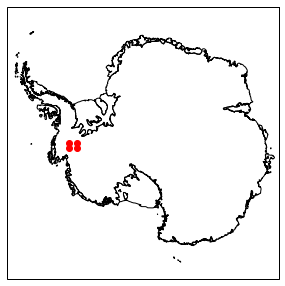

In [2]:
ncol = 168
nrow = 107

# Define upper left and lower right domain corners in epsg 3031
ulx = -1542000 # done
lry = -109000 # done

uly = lry + 1000 * (nrow -1)
lrx = ulx + 1000 * (ncol -1)


# Plot corners on map
# Coastline Data
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(5, 5))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot model domain
plt.scatter(ulx, lry, c='r')
plt.scatter(ulx, uly, c='r')
plt.scatter(lrx, lry, c='r')
plt.scatter(lrx, uly, c='r')

## Load MERRA-2 lat/lon

In [3]:
# Load lat, lon
ds = xr.open_dataset("/scratch/summit/erke2265/MERRA2/T2M_hourly_1980.nc")
grid_lat = ds['lat'].values
grid_lon = ds['lon'].values

# Create lat/lon arrays and reshape into vectors. To undo flatten, np.reshape(grid_lon, [len(ds['lat']), len(ds['lon'])])
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)
grid_lon = grid_lon.flatten()
grid_lat = grid_lat.flatten()

## Convert MERRA-2 lat/lon to epsg 3031

In [4]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
grid_X = np.zeros(len(grid_lon)); grid_X[:] = np.nan
grid_Y = np.zeros(len(grid_lat)); grid_Y[:] = np.nan

# Perform coordinate transformation
for j in range(0, len(grid_X)):
    coords = transform.TransformPoint(grid_lat[j], grid_lon[j])
    grid_X[j], grid_Y[j] = coords[0:2]


## Determine which MERRA-2 grid cell are within the Alpine3D domain

In [5]:
def get_domain(gridX, gridY, domain_left, domain_right, domain_bottom, domain_top):
    filter_func = np.vectorize(lambda gridX, gridY: gridX <= domain_right and gridX >= domain_left and gridY >= domain_bottom and gridY <= domain_top)
    
    gridX_filter = gridX[filter_func(gridX, gridY)]
    gridY_filter = gridY[filter_func(gridX, gridY)]
    
    return gridX_filter, gridY_filter

# Call filter function
gridX_filter, gridY_filter = get_domain(grid_X, grid_Y, ulx, lrx, lry, uly)

## Convert MERRA-2 coordinates back into regular lat/lon

In [6]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(3031) # WGS-84
tgt.ImportFromEPSG(4326) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
filter_X = np.zeros(len(gridX_filter)); filter_X[:] = np.nan
filter_Y = np.zeros(len(gridY_filter)); filter_Y[:] = np.nan

# Perform coordinate transformation
for j in range(0, len(filter_X)):
    coords = transform.TransformPoint(gridX_filter[j], gridY_filter[j])
    filter_X[j], filter_Y[j] = coords[0:2]



## Write station_list.lst

In [7]:
f = open("station_list.lst",'w')
f.write("[INPUT]\n")

for j in range(0, len(filter_X)):
    index = str(j + 1)
    lat = str(round(filter_X[j], 3))
    lon = str(round(filter_Y[j], 3))
    
    f.write("VSTATION" + index + " = latlon " + lat + " " + lon + " 0\n")
    
f.close()

!cat station_list.lst

[INPUT]
VSTATION1 = latlon -77.0 -94.375 0
VSTATION2 = latlon -77.0 -93.75 0
VSTATION3 = latlon -77.0 -93.125 0
VSTATION4 = latlon -77.0 -92.5 0
VSTATION5 = latlon -77.0 -91.875 0
VSTATION6 = latlon -77.0 -91.25 0
VSTATION7 = latlon -77.0 -90.625 0
VSTATION8 = latlon -76.5 -93.75 0
VSTATION9 = latlon -76.5 -93.125 0
VSTATION10 = latlon -76.5 -92.5 0
VSTATION11 = latlon -76.5 -91.875 0
VSTATION12 = latlon -76.5 -91.25 0
VSTATION13 = latlon -76.5 -90.625 0
VSTATION14 = latlon -76.0 -93.75 0
VSTATION15 = latlon -76.0 -93.125 0
VSTATION16 = latlon -76.0 -92.5 0
VSTATION17 = latlon -76.0 -91.875 0
VSTATION18 = latlon -76.0 -91.25 0
VSTATION19 = latlon -76.0 -90.625 0
